# Trust in Law Enforcement: Understanding the Drivers of Police Sentiment Scores

### Highlights

- Since the intent of the study is to understand the drivers of police sentiment scores, there was emphasis on researching and gathering multiple datasets, regarding geography, race, housing, socio-economics, crime volume, and even basic public health indicators on mortality (e.g. causes of death) and natality (e.g. teen pregnancy). This was cast a wide net on the possible features to consider.  Each dataset needed to be cleaned separately, before incorporating them into the design matrix.
- For the same reason, there is also much importance placed on feature selection and ranking of predictor variables, as well as interpretability.
    - Linear regression with Lasso regularization was especially useful in feature selection.
    - Conversely, kNN was not useful since it does not yield insight on the top predictors.
- Also, with more features to consider, there was more to be done on data exploration. Correlation heatmaps and pairwise scatterplots were particularly useful.
- Since the dataset consists of Community Areas in the city of Chicago, resulting in a limited number of observations, Repeated KFold cross-validation was performed to increase accuracy. Indeed, it resulted in much better accuracy compared to KFold. High values for n_splits close to the sample size was attempted, to make the most of each observation (approximating LOOCV), however it was found that n_splits=6 yielded the best results.
- For educational purposes, sklearn.pipeline.Pipeline and sklearn.model_selection.GridSearchCV was studied and used.

### Data Cleaning and Pre-Processing

In [215]:
# Import libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
import time
pd.set_option('display.max_colwidth', None)

In [19]:
# First, load socioeconomic data
df_socio = pd.read_csv('Features - socioeconomic.csv')
display(df_socio)
# print(df_socio.dtypes)

,COMMUNITY_AREA_NUMBER,COMMUNITY_AREA_NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER_CAPITA_INCOME,HARDSHIP_INDEX
0,1,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39
1,2,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46
2,3,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20
3,4,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17
4,5,North Center,0.3,7.5,5.2,4.5,26.2,57123,6
...,...,...,...,...,...,...,...,...,...
72,73,Washington Heights,1.1,16.9,20.8,13.7,42.6,19713,48
73,74,Mount Greenwood,1.0,3.4,8.7,4.3,36.8,34381,16
74,75,Morgan Park,0.8,13.2,15.0,10.8,40.3,27149,30
75,76,O'Hare,3.6,15.4,7.1,10.9,30.3,25828,24


##### Cleaning of socio-economic data

In [20]:
# Convert column headers to titlecase
df_socio.columns = df_socio.columns.str.title()

# Convert first column to integer type
df_socio['Community_Area_Number'] = df_socio['Community_Area_Number'].astype(int)

df_socio

,Community_Area_Number,Community_Area_Name,Percent Of Housing Crowded,Percent Households Below Poverty,Percent Aged 16+ Unemployed,Percent Aged 25+ Without High School Diploma,Percent Aged Under 18 Or Over 64,Per_Capita_Income,Hardship_Index
0,1,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39
1,2,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46
2,3,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20
3,4,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17
4,5,North Center,0.3,7.5,5.2,4.5,26.2,57123,6
...,...,...,...,...,...,...,...,...,...
72,73,Washington Heights,1.1,16.9,20.8,13.7,42.6,19713,48
73,74,Mount Greenwood,1.0,3.4,8.7,4.3,36.8,34381,16
74,75,Morgan Park,0.8,13.2,15.0,10.8,40.3,27149,30
75,76,O'Hare,3.6,15.4,7.1,10.9,30.3,25828,24


In [21]:
# Next, load geographic data
df_geog = pd.read_csv('Features - geographic.csv')
display(df_geog.head())
# print(df_geog.dtypes)

,COMMUNITY_AREA_NUMBER,COMMUNITY_AREA_NAME,Area_sqkm,Latitude,Longitude
0,1,Rogers Park,4.77,42.011937,-87.670152
1,2,West Ridge,9.14,41.999557,-87.693110
2,3,Uptown,6.01,41.966053,-87.657373
3,4,Lincoln Square,6.63,41.972285,-87.689206
4,5,North Center,5.31,41.947516,-87.683101


In [22]:
# Convert column headers to titlecase
df_geog.columns = df_geog.columns.str.title()
df_geog

,Community_Area_Number,Community_Area_Name,Area_Sqkm,Latitude,Longitude
0,1,Rogers Park,4.77,42.011937,-87.670152
1,2,West Ridge,9.14,41.999557,-87.693110
2,3,Uptown,6.01,41.966053,-87.657373
3,4,Lincoln Square,6.63,41.972285,-87.689206
4,5,North Center,5.31,41.947516,-87.683101
...,...,...,...,...,...
72,73,Washington Heights,7.41,41.719433,-87.649769
73,74,Mount Greenwood,7.02,41.694318,-87.708096
74,75,Morgan Park,8.55,41.689622,-87.663627
75,76,O'Hare,34.55,41.976592,-87.878130


In [23]:
# Next, load crime data
df_crime = pd.read_csv('Features - crime 2020.csv')
df_crime.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,12014684,JD189901,03/17/2020 09:30:00 PM,039XX N LECLAIRE AVE,820,THEFT,$500 AND UNDER,STREET,False,False,...,45.0,15.0,6,1141659.0,1925649.0,2020,03/25/2020 03:45:43 PM,41.952052,-87.754660,"(41.952051946, -87.754660372)"
1,12012127,JD189186,03/18/2020 02:03:00 AM,039XX W JACKSON BLVD,910,MOTOR VEHICLE THEFT,AUTOMOBILE,APARTMENT,False,True,...,28.0,26.0,7,1150196.0,1898398.0,2020,03/25/2020 03:47:29 PM,41.877110,-87.723990,"(41.877110187, -87.723989719)"
2,12012330,JD189367,03/18/2020 08:50:00 AM,023XX N KEELER AVE,560,ASSAULT,SIMPLE,RESIDENCE,False,False,...,35.0,20.0,08A,1147996.0,1915240.0,2020,03/25/2020 03:47:29 PM,41.923369,-87.731634,"(41.923368973, -87.731633833)"
3,12014760,JD192130,03/18/2020 01:00:00 PM,047XX W MONROE ST,1150,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,OTHER (SPECIFY),False,False,...,28.0,25.0,11,1144749.0,1899145.0,2020,03/25/2020 03:47:29 PM,41.879264,-87.743971,"(41.879264422, -87.743970898)"
4,12012667,JD189808,03/18/2020 05:35:00 PM,003XX S CICERO AVE,2017,NARCOTICS,MANUFACTURE / DELIVER - CRACK,SIDEWALK,True,False,...,28.0,25.0,18,1144446.0,1898000.0,2020,03/25/2020 03:47:29 PM,41.876128,-87.745112,"(41.876128106, -87.745112291)"


In [24]:
# Retrieve only crime count per community area
df_crime = df_crime.groupby('Community Area')[['ID']].count().reset_index()

# Rename columns
df_crime.columns = ['Community_Area_Number', 'Crimes']

# Convert Community Area column to integer type
df_crime['Community_Area_Number'] = df_crime['Community_Area_Number'].astype(int)

df_crime

,Community_Area_Number,Crimes
0,1,3279
1,2,3089
2,3,2936
3,4,1879
4,5,1148
...,...,...
72,73,2656
73,74,514
74,75,1681
75,76,1212


In [25]:
# Load demographic data on ethnicity and housing
df_demog = pd.read_csv('Features - ethnicity and housing.csv')
display(df_demog.head())
# print(df_demog.dtypes)

,COMMUNITY_AREA_NUMBER,COMMUNITY_AREA_NAME,Pop_Total,Pop_Households,Pop_GroupQuarters,Pop_Hispanic,Pop_White,Pop_Black,Pop_Asian,Pop_Other,Housing_Units,HU_Occupied,HU_Vacant,Ave_Household_size
0,1,Rogers Park,55628,52242,3386,12587,22292,13819,3820,3110,28531,26402,2129,1.978714
1,2,West Ridge,77122,75531,1591,15307,28212,10484,19815,3304,28249,26493,1756,2.850980
2,3,Uptown,57182,55082,2100,7587,29871,10800,6182,2742,35019,32215,2804,1.709825
3,4,Lincoln Square,40494,39969,525,7069,25342,1601,4516,1966,20431,19143,1288,2.087917
4,5,North Center,35114,35058,56,4503,25799,780,2162,1870,15936,14931,1005,2.348001


In [26]:
# Convert column headers to titlecase
df_demog.columns = df_demog.columns.str.title()

# Express population counts per segment (per housing type and ethnicity)
# as proportions of total population
df_demog.iloc[:, 3:10] = df_demog.iloc[:, 3:10].to_numpy() / df_demog[['Pop_Total']].to_numpy()

# Express housing type counts as proportion of total housing units
df_demog.iloc[:, 11:13] = df_demog.iloc[:, 11:13].to_numpy() / df_demog[['Housing_Units']].to_numpy()

# Drop columns column on occupied housing units, since it is perfectly
# negatively correlated related to vacant housing units
df_demog = df_demog.drop(['Hu_Occupied'], axis=1)

# Drop columns column on population living in households, since it is perfectly
# negatively correlated to the population living in group quarters
df_demog = df_demog.drop(['Pop_Households'], axis=1)

df_demog

,Community_Area_Number,Community_Area_Name,Pop_Total,Pop_Groupquarters,Pop_Hispanic,Pop_White,Pop_Black,Pop_Asian,Pop_Other,Housing_Units,Hu_Vacant,Ave_Household_Size
0,1,Rogers Park,55628,0.060869,0.226271,0.400733,0.248418,0.068670,0.055907,28531,0.074621,1.978714
1,2,West Ridge,77122,0.020630,0.198478,0.365810,0.135940,0.256931,0.042841,28249,0.062161,2.850980
2,3,Uptown,57182,0.036725,0.132682,0.522385,0.188871,0.108111,0.047952,35019,0.080071,1.709825
3,4,Lincoln Square,40494,0.012965,0.174569,0.625821,0.039537,0.111523,0.048550,20431,0.063041,2.087917
4,5,North Center,35114,0.001595,0.128239,0.734721,0.022213,0.061571,0.053255,15936,0.063065,2.348001
...,...,...,...,...,...,...,...,...,...,...,...,...
72,73,Washington Heights,25065,0.006543,0.021704,0.003790,0.951486,0.001237,0.021783,10451,0.087360,2.610715
73,74,Mount Greenwood,18628,0.018682,0.107043,0.818982,0.040423,0.006227,0.027324,7298,0.061387,2.668613
74,75,Morgan Park,21186,0.025961,0.045502,0.275559,0.644246,0.003446,0.031247,8865,0.077834,2.524281
75,76,O'Hare,13418,0.000820,0.111194,0.683708,0.028693,0.145923,0.030481,6560,0.061280,2.177168


In [27]:
# Load public health data
df_health = pd.read_csv('Features - public health.csv')
display(df_health.head())

# Display column types and null value counts
display(pd.concat([df_health.dtypes, df_health.isnull().sum()], axis=1).
        rename(columns={0:'dtype', 1:'NaN'}))

,Community_Area_Number,Community_Area_Name,Birth Rate,Nat_General Fertility Rate,Nat_Low Birth Weight,Nat_Prenatal Care Beginning in First Trimester,Nat_Preterm Births,Nat_Teen Birth Rate,Mort_Assault (Homicide),Mort_Breast cancer in females,...,Lead_Childhood Lead Poisoning,Infect_Gonorrhea in Females,Infect_Gonorrhea in Males,Infect_Tuberculosis,Econ_Below Poverty Level,Econ_Crowded Housing,Econ_Dependency,Econ_No High School Diploma,Econ_Per Capita Income,Econ_Unemployment
0,1,Rogers Park,16.4,62.0,11.0,73.0,11.2,40.8,7.7,23.3,...,0.5,322.5,423.3,11.4,22.7,7.9,28.8,18.1,23714,7.5
1,2,West Ridge,17.3,83.3,8.1,71.1,8.3,29.9,5.8,20.2,...,1.0,141.0,205.7,8.9,15.1,7.0,38.3,19.6,21375,7.9
2,3,Uptown,13.1,50.5,8.3,77.7,10.3,35.1,5.4,21.3,...,0.5,170.8,468.7,13.6,22.7,4.6,22.2,13.6,32355,7.7
3,4,Lincoln Square,17.1,61.0,8.1,80.5,9.7,38.4,5.0,21.7,...,0.4,98.8,195.5,8.5,9.5,3.1,25.6,12.5,35503,6.8
4,5,North Center,22.4,76.2,9.1,80.4,9.8,8.4,1.0,16.6,...,0.9,85.4,188.6,1.9,7.1,0.2,25.5,5.4,51615,4.5


,dtype,NaN
Community_Area_Number,int64,0
Community_Area_Name,object,0
Birth Rate,float64,0
Nat_General Fertility Rate,float64,0
Nat_Low Birth Weight,float64,0
Nat_Prenatal Care Beginning in First Trimester,float64,0
Nat_Preterm Births,float64,0
Nat_Teen Birth Rate,float64,0
Mort_Assault (Homicide),float64,0
Mort_Breast cancer in females,float64,0


In [28]:
# Remove non-health-related data, i.e. columns that are redundant
# with previously loaded socio-economic data
df_health = df_health.iloc[:, :-6]

# Remove features with null values (falling under columns related
# to lead screening and infectious diseases)
df_health = df_health.dropna(axis=1)

# Other public health features are unlikely to be good predictors
# of police sentiment, retain only the key public health metrics
# (natality and mortality metrics)
df_health = df_health.drop(['Infect_Gonorrhea in Males',
                            'Infect_Tuberculosis'], axis=1)

df_health

,Community_Area_Number,Community_Area_Name,Birth Rate,Nat_General Fertility Rate,Nat_Low Birth Weight,Nat_Prenatal Care Beginning in First Trimester,Nat_Preterm Births,Nat_Teen Birth Rate,Mort_Assault (Homicide),Mort_Breast cancer in females,Mort_Cancer (All Sites),Mort_Colorectal Cancer,Mort_Diabetes-related,Mort_Firearm-related,Mort_Infant Mortality Rate,Mort_Lung Cancer,Mort_Prostate Cancer in Males,Mort_Stroke (Cerebrovascular Disease)
0,1,Rogers Park,16.4,62.0,11.0,73.0,11.2,40.8,7.7,23.3,176.9,25.3,77.1,5.2,6.4,36.7,21.7,33.7
1,2,West Ridge,17.3,83.3,8.1,71.1,8.3,29.9,5.8,20.2,155.9,17.3,60.5,3.7,5.1,36.0,14.2,34.7
2,3,Uptown,13.1,50.5,8.3,77.7,10.3,35.1,5.4,21.3,183.3,20.5,80.0,4.6,6.5,50.5,25.2,41.7
3,4,Lincoln Square,17.1,61.0,8.1,80.5,9.7,38.4,5.0,21.7,153.2,8.6,55.4,6.1,3.8,43.1,27.6,36.9
4,5,North Center,22.4,76.2,9.1,80.4,9.8,8.4,1.0,16.6,152.1,26.1,49.8,1.0,2.7,42.4,15.1,41.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,73,Washington Heights,12.0,61.0,19.6,75.4,16.2,65.0,38.0,47.9,260.6,29.7,79.5,35.6,11.2,70.0,56.2,57.6
73,74,Mount Greenwood,12.5,59.0,8.4,94.5,15.1,7.7,2.2,34.6,201.1,24.8,66.5,7.4,3.3,55.0,16.9,26.7
74,75,Morgan Park,13.2,67.5,10.6,74.5,12.3,46.7,19.9,32.4,218.2,27.1,75.4,15.8,13.1,50.0,39.8,47.9
75,76,O'Hare,15.8,70.0,3.5,82.0,5.0,15.9,5.6,20.5,138.5,8.7,47.3,11.8,2.0,37.4,2.8,40.4


In [156]:
df_all = df_geog.copy()
df_all = df_all.merge(df_socio.drop('Community_Area_Name', axis=1),
                      on='Community_Area_Number')
df_all = df_all.merge(df_crime, on='Community_Area_Number')
df_all = df_all.merge(df_demog.drop('Community_Area_Name', axis=1),
                      on='Community_Area_Number')
# df_all = df_all.merge(df_health.drop('Community_Area_Name', axis=1),
#                       on='Community_Area_Number')
df_all = df_all.set_index(df_all['Community_Area_Number'].astype(str)
                          + ' - '
                          + df_all['Community_Area_Name'])
df_all = df_all.drop(['Community_Area_Number', 'Community_Area_Name'], axis=1)
df_all

,Area_Sqkm,Latitude,Longitude,Percent Of Housing Crowded,Percent Households Below Poverty,Percent Aged 16+ Unemployed,Percent Aged 25+ Without High School Diploma,Percent Aged Under 18 Or Over 64,Per_Capita_Income,Hardship_Index,...,Pop_Total,Pop_Groupquarters,Pop_Hispanic,Pop_White,Pop_Black,Pop_Asian,Pop_Other,Housing_Units,Hu_Vacant,Ave_Household_Size
1 - Rogers Park,4.77,42.011937,-87.670152,7.7,23.6,8.7,18.2,27.5,23939,39,...,55628,0.060869,0.226271,0.400733,0.248418,0.068670,0.055907,28531,0.074621,1.978714
2 - West Ridge,9.14,41.999557,-87.693110,7.8,17.2,8.8,20.8,38.5,23040,46,...,77122,0.020630,0.198478,0.365810,0.135940,0.256931,0.042841,28249,0.062161,2.850980
3 - Uptown,6.01,41.966053,-87.657373,3.8,24.0,8.9,11.8,22.2,35787,20,...,57182,0.036725,0.132682,0.522385,0.188871,0.108111,0.047952,35019,0.080071,1.709825
4 - Lincoln Square,6.63,41.972285,-87.689206,3.4,10.9,8.2,13.4,25.5,37524,17,...,40494,0.012965,0.174569,0.625821,0.039537,0.111523,0.048550,20431,0.063041,2.087917
5 - North Center,5.31,41.947516,-87.683101,0.3,7.5,5.2,4.5,26.2,57123,6,...,35114,0.001595,0.128239,0.734721,0.022213,0.061571,0.053255,15936,0.063065,2.348001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73 - Washington Heights,7.41,41.719433,-87.649769,1.1,16.9,20.8,13.7,42.6,19713,48,...,25065,0.006543,0.021704,0.003790,0.951486,0.001237,0.021783,10451,0.087360,2.610715
74 - Mount Greenwood,7.02,41.694318,-87.708096,1.0,3.4,8.7,4.3,36.8,34381,16,...,18628,0.018682,0.107043,0.818982,0.040423,0.006227,0.027324,7298,0.061387,2.668613
75 - Morgan Park,8.55,41.689622,-87.663627,0.8,13.2,15.0,10.8,40.3,27149,30,...,21186,0.025961,0.045502,0.275559,0.644246,0.003446,0.031247,8865,0.077834,2.524281
76 - O'Hare,34.55,41.976592,-87.878130,3.6,15.4,7.1,10.9,30.3,25828,24,...,13418,0.000820,0.111194,0.683708,0.028693,0.145923,0.030481,6560,0.061280,2.177168


In [157]:
df_all.describe()

,Area_Sqkm,Latitude,Longitude,Percent Of Housing Crowded,Percent Households Below Poverty,Percent Aged 16+ Unemployed,Percent Aged 25+ Without High School Diploma,Percent Aged Under 18 Or Over 64,Per_Capita_Income,Hardship_Index,...,Pop_Total,Pop_Groupquarters,Pop_Hispanic,Pop_White,Pop_Black,Pop_Asian,Pop_Other,Housing_Units,Hu_Vacant,Ave_Household_Size
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,...,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,7.763766,41.839419,-87.674538,4.923377,21.766234,15.372727,20.341558,35.746753,25563.168831,49.506494,...,35667.376623,0.014191,0.277002,0.259801,0.368401,0.065467,0.029328,16397.558442,0.094825,2.527401
std,5.108717,0.098939,0.068640,3.682887,11.529957,7.543412,11.823152,7.327716,15293.098259,28.690556,...,23675.473010,0.022040,0.281319,0.262237,0.382458,0.110733,0.013126,13318.328338,0.044187,0.489419
min,1.500000,41.655743,-87.878130,0.300000,3.300000,4.700000,2.500000,13.500000,8201.000000,1.000000,...,2527.000000,0.000000,0.015011,0.001583,0.005380,0.000794,0.005941,1192.000000,0.034383,1.556212
25%,4.610000,41.762572,-87.718676,2.300000,13.200000,9.200000,11.800000,32.000000,15754.000000,25.000000,...,18628.000000,0.001682,0.061217,0.027659,0.037447,0.002885,0.020046,7298.000000,0.062161,2.186270
50%,7.410000,41.830268,-87.668505,3.800000,18.900000,13.900000,18.500000,38.100000,21323.000000,50.000000,...,29647.000000,0.005719,0.150384,0.117075,0.135940,0.020969,0.026564,12772.000000,0.085273,2.501150
75%,9.190000,41.926836,-87.624026,6.800000,29.200000,20.000000,26.600000,40.500000,28887.000000,74.000000,...,45053.000000,0.016142,0.468799,0.452174,0.815681,0.080920,0.038321,20431.000000,0.122628,2.785216
max,34.550000,42.011937,-87.534985,15.800000,56.500000,35.900000,54.800000,51.500000,88669.000000,98.000000,...,105481.000000,0.098486,0.913809,0.827592,0.954746,0.722318,0.061753,77429.000000,0.239902,3.816092


In [158]:
df_targets = pd.read_csv('Target - Police sentiment.csv')
df_targets.head()

,COMMUNITY_AREA_NUMBER,COMMUNITY_AREA_NAME,Police District,Safety_Score,Trust_Score
0,1,Rogers Park,District24,63.229,64.549
1,2,West Ridge,District24,63.229,64.549
2,3,Uptown,District19,66.875,67.906
3,4,Lincoln Square,District20,67.803,66.445
4,5,North Center,District19,66.875,67.906


In [32]:
# Convert column headers to titlecase
df_targets.columns = df_targets.columns.str.title()

# Drop redundant column
df_targets = df_targets.drop('Police District', axis=1)

# Set index
df_targets = df_targets.set_index(df_targets['Community_Area_Number'].astype(str)
                                  + ' - '
                                  + df_targets['Community_Area_Name'])
df_targets = df_targets.drop(['Community_Area_Number', 'Community_Area_Name'], axis=1)

df_targets

,Safety_Score,Trust_Score
1 - Rogers Park,63.229,64.549
2 - West Ridge,63.229,64.549
3 - Uptown,66.875,67.906
4 - Lincoln Square,67.803,66.445
5 - North Center,66.875,67.906
...,...,...
73 - Washington Heights,60.433,64.427
74 - Mount Greenwood,60.433,64.427
75 - Morgan Park,60.433,64.427
76 - O'Hare,68.164,75.265


### Data Exploration

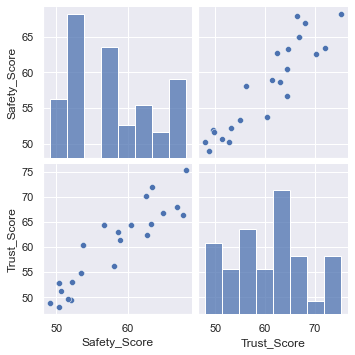

In [33]:
sns.set(style="darkgrid")
sns.pairplot(df_targets)
plt.show()

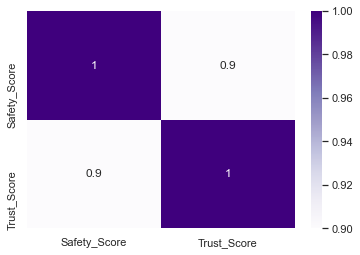

In [34]:
sns.heatmap(df_targets.corr().round(2), cmap='Purples', annot=True)
plt.show()

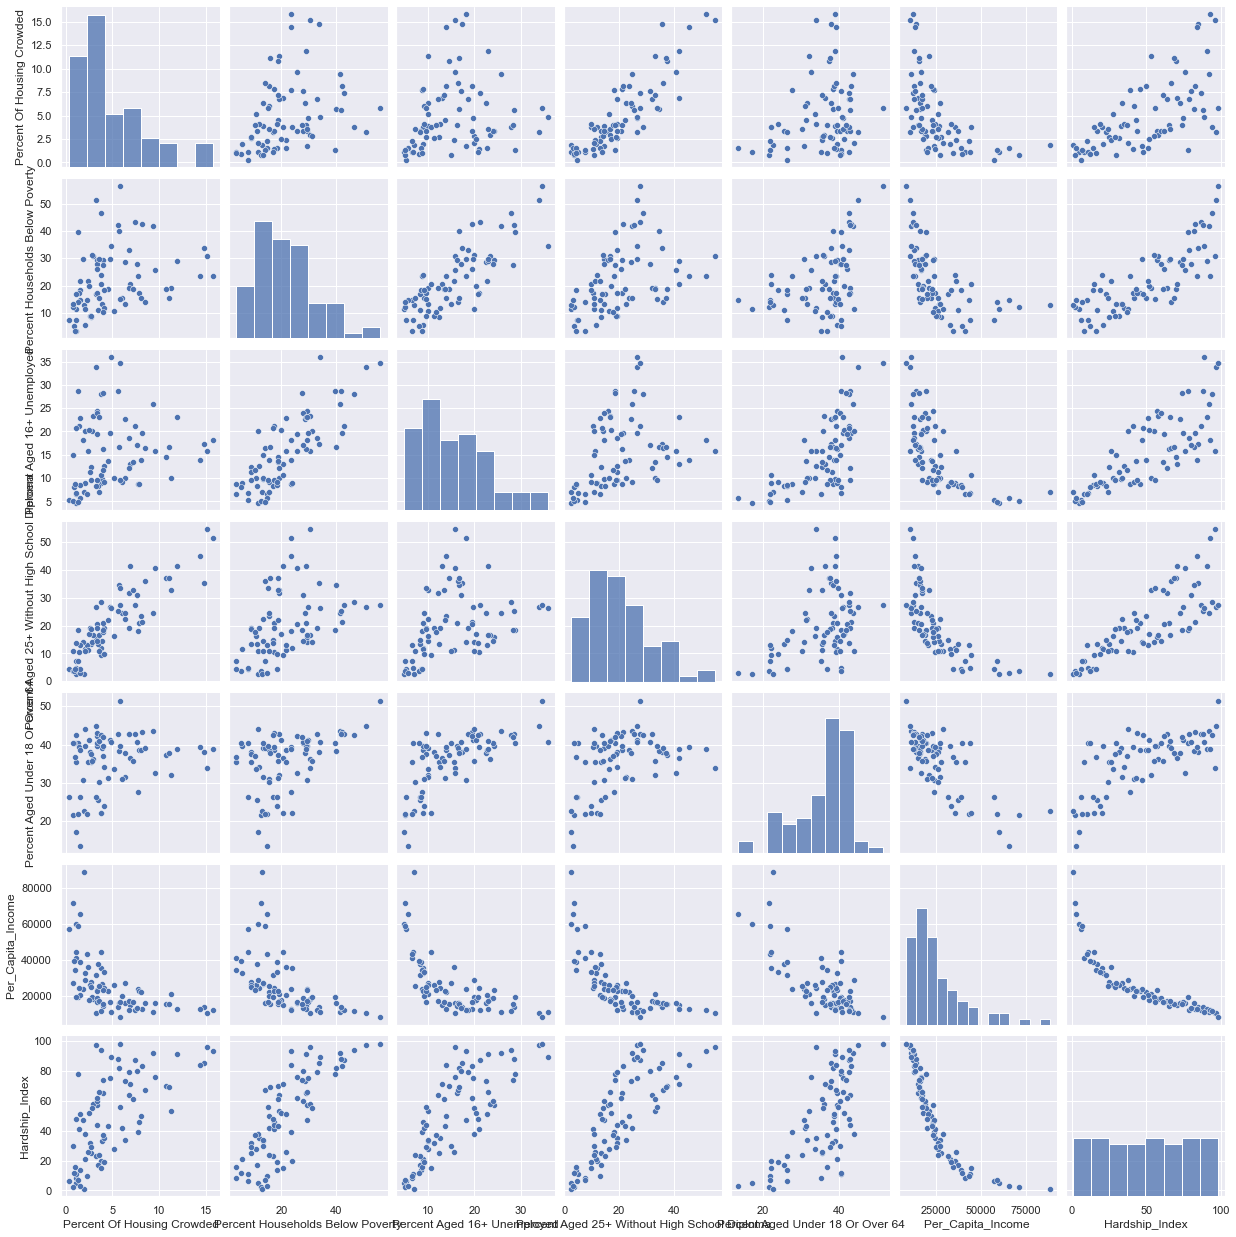

In [35]:
sns.set(style="darkgrid")
sns.pairplot(df_socio.set_index(['Community_Area_Number',
                                 'Community_Area_Name']))
plt.show()

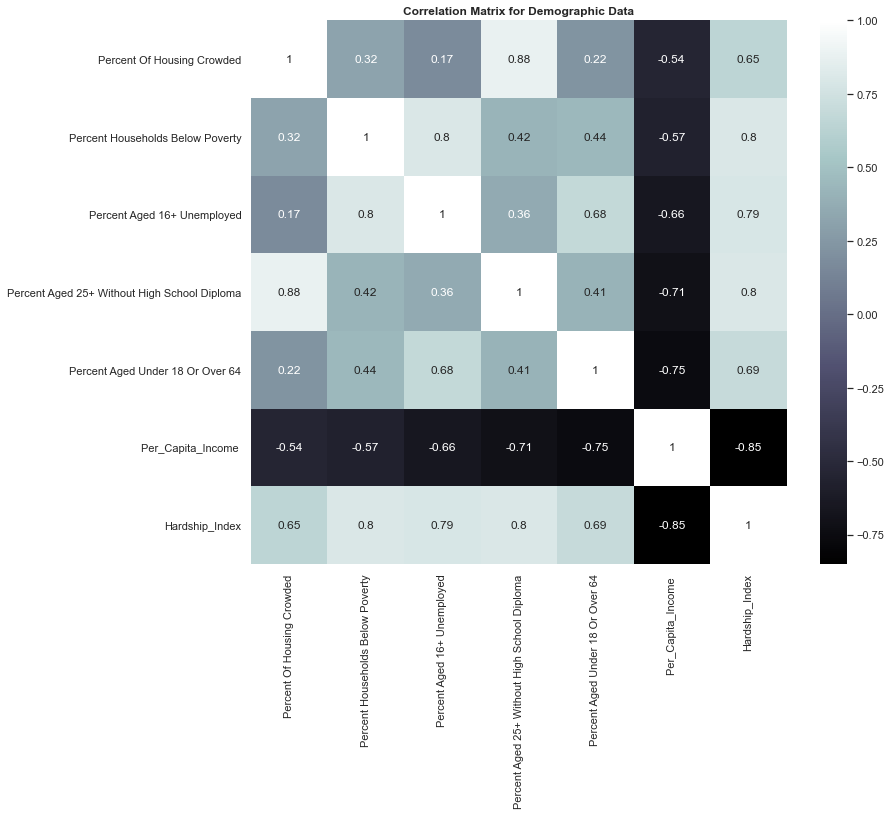

In [36]:
fig, ax = plt.subplots(figsize=(12, 10))
fig = sns.heatmap(df_socio.set_index(['Community_Area_Number',
                                      'Community_Area_Name']).
                  corr().round(2), cmap='bone', annot=True, ax=ax)
fig.set_title('Correlation Matrix for Demographic Data', weight='bold')
plt.show()

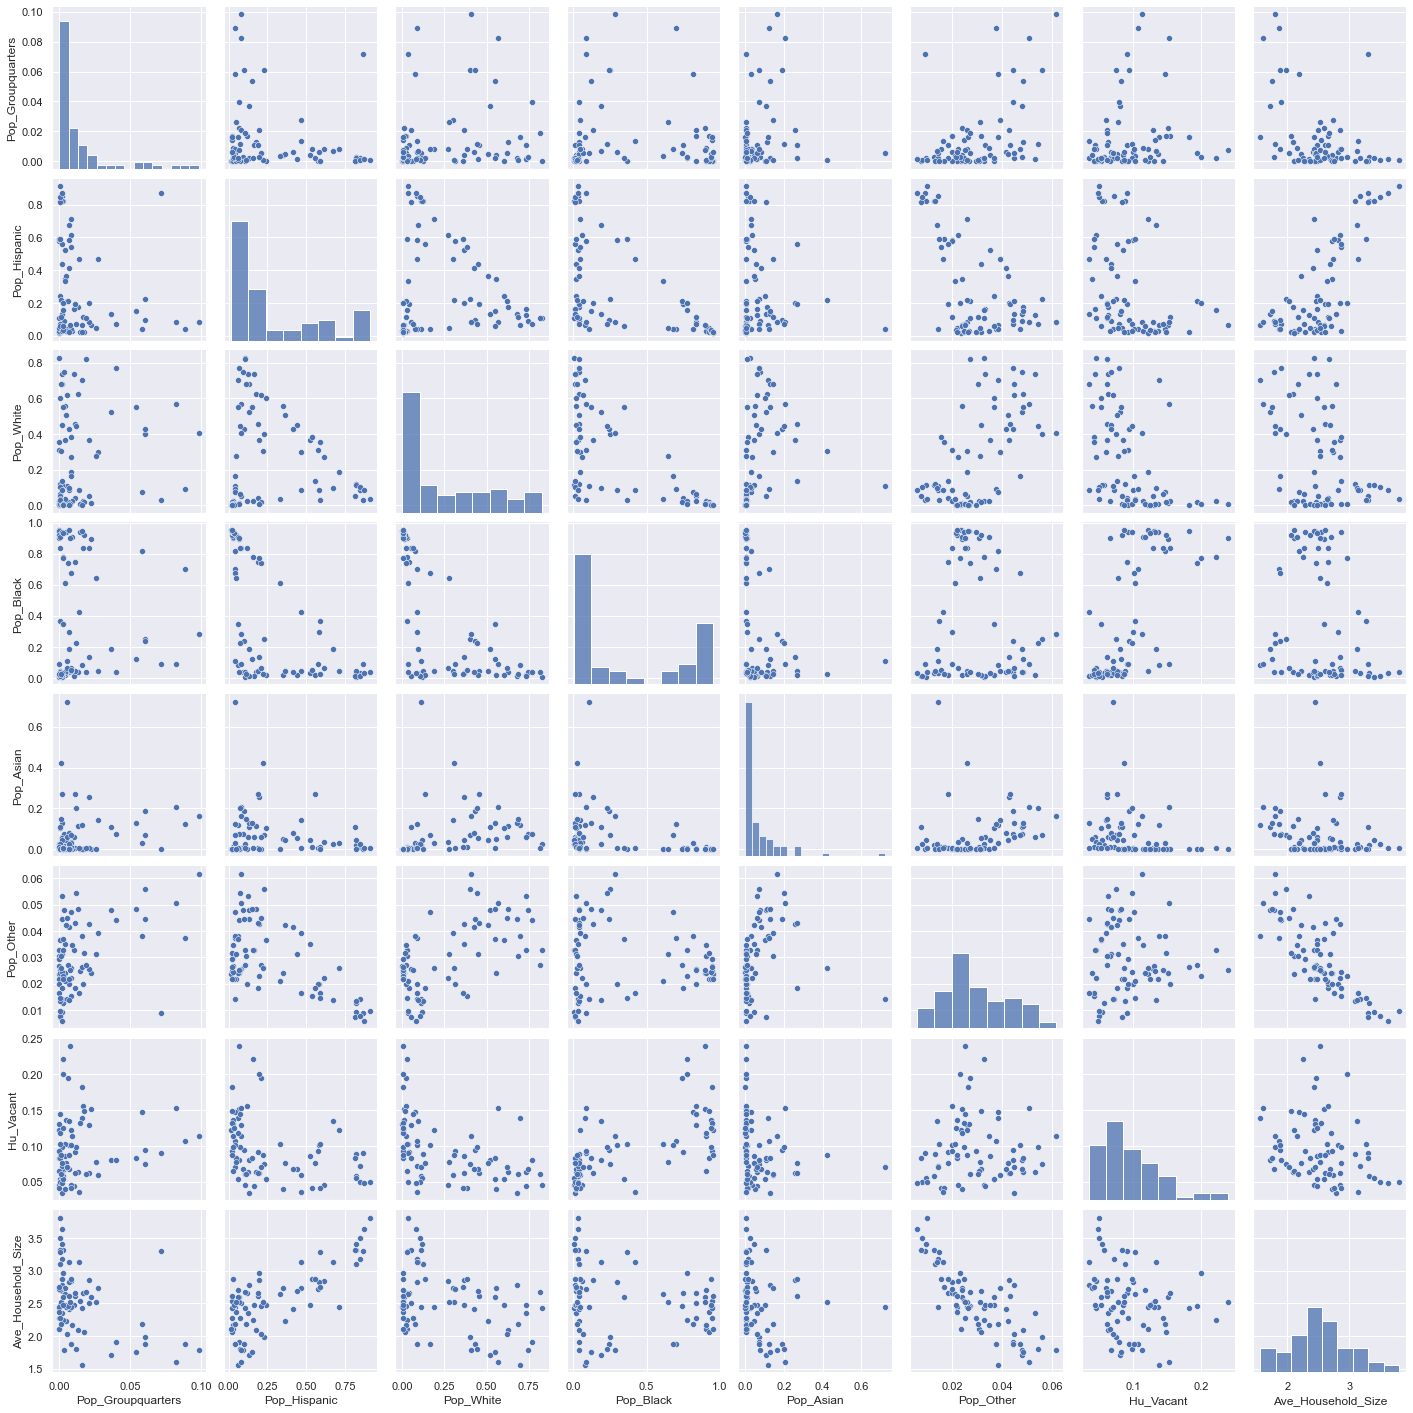

In [37]:
sns.set(style="darkgrid")
sns.pairplot(df_demog.set_index(['Community_Area_Number',
                                 'Community_Area_Name']).
             drop(['Pop_Total', 'Housing_Units'], axis=1))
plt.show()

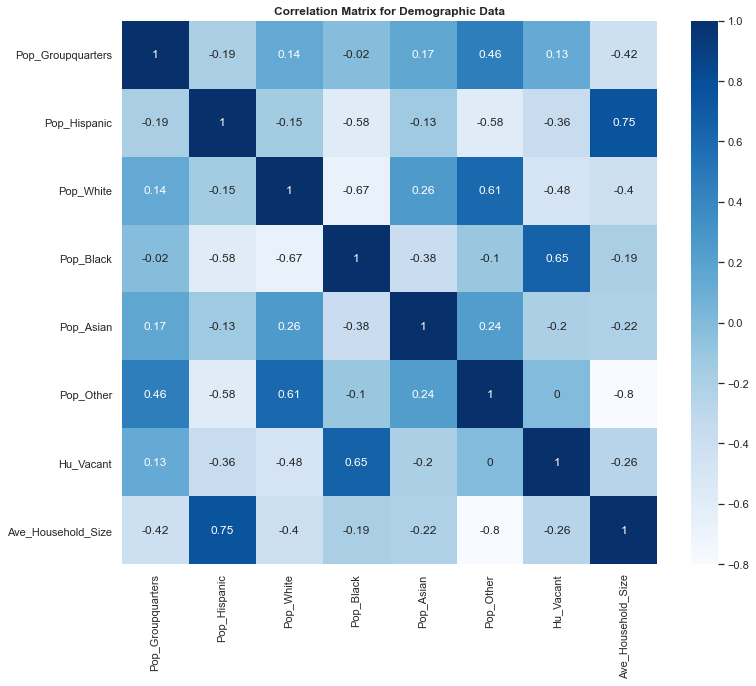

In [38]:
fig, ax = plt.subplots(figsize=(12, 10))
fig = sns.heatmap(df_demog.set_index(['Community_Area_Number',
                                      'Community_Area_Name']).
                  drop(['Pop_Total', 'Housing_Units'], axis=1).
                  corr().round(2), cmap='Blues', annot=True, ax=ax)
fig.set_title('Correlation Matrix for Demographic Data', weight='bold')
plt.show()

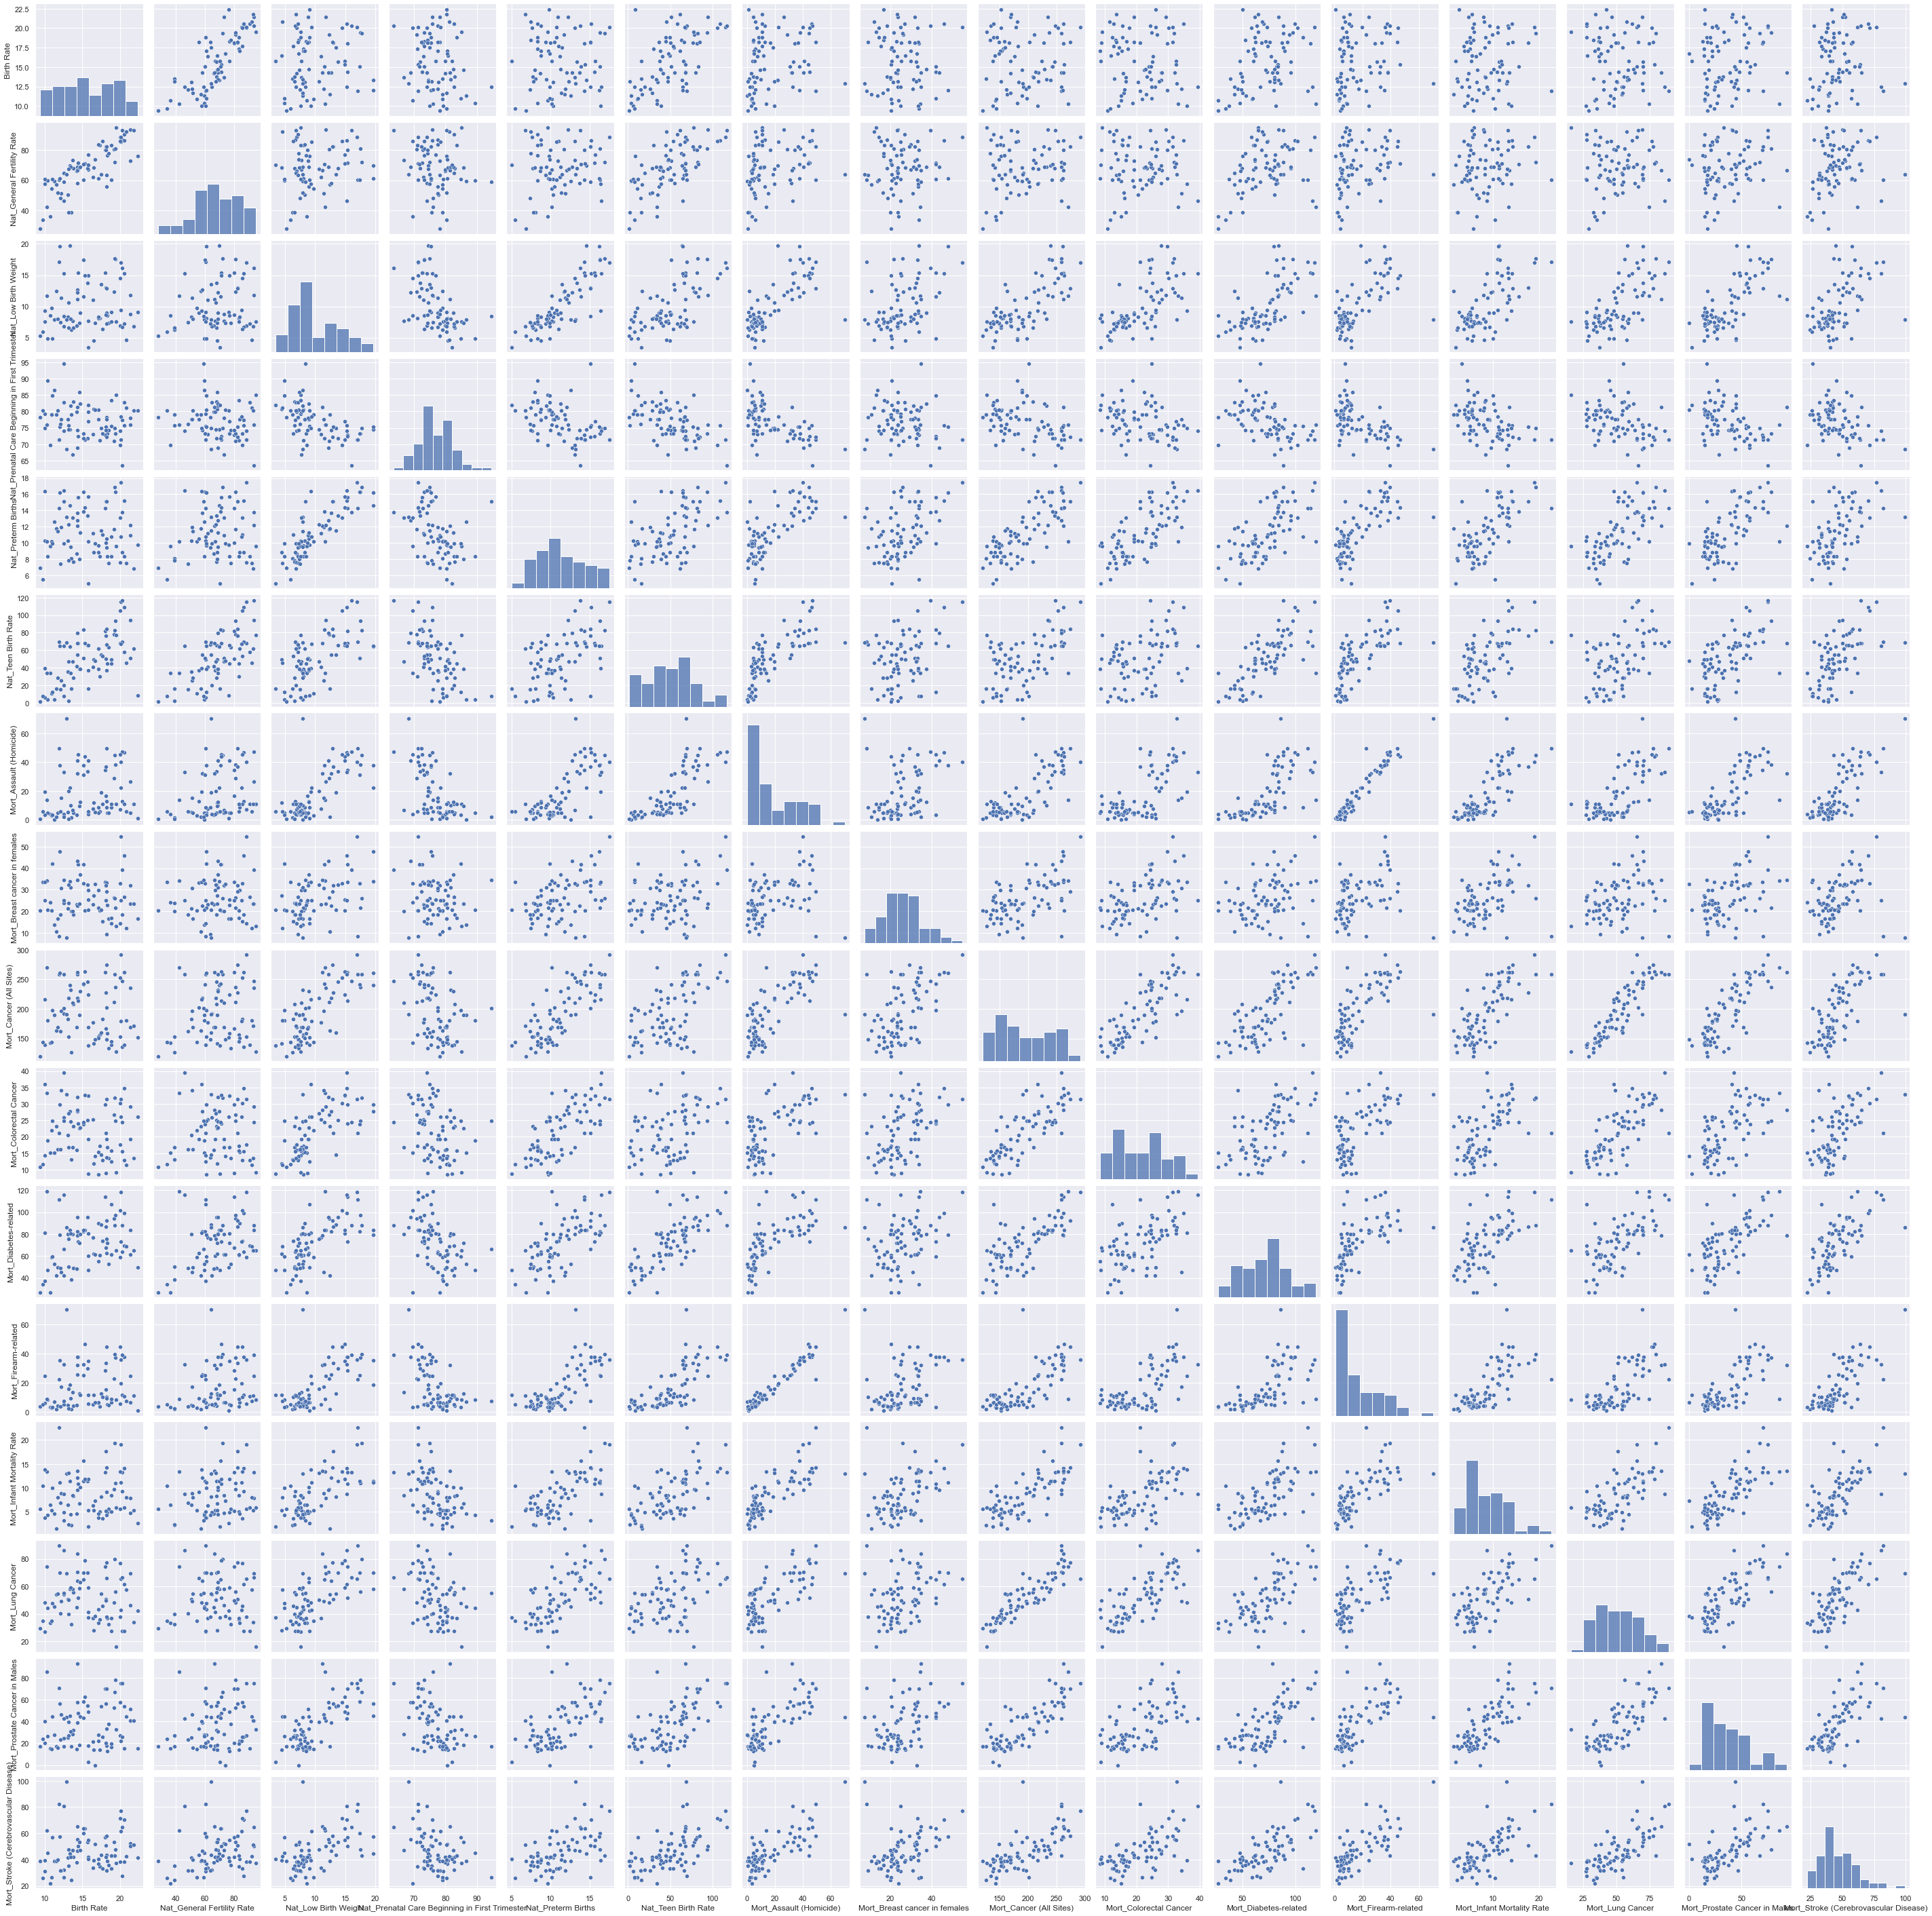

In [39]:
sns.set(style="darkgrid")
sns.pairplot(df_health.set_index(['Community_Area_Number',
                                 'Community_Area_Name']))
plt.show()

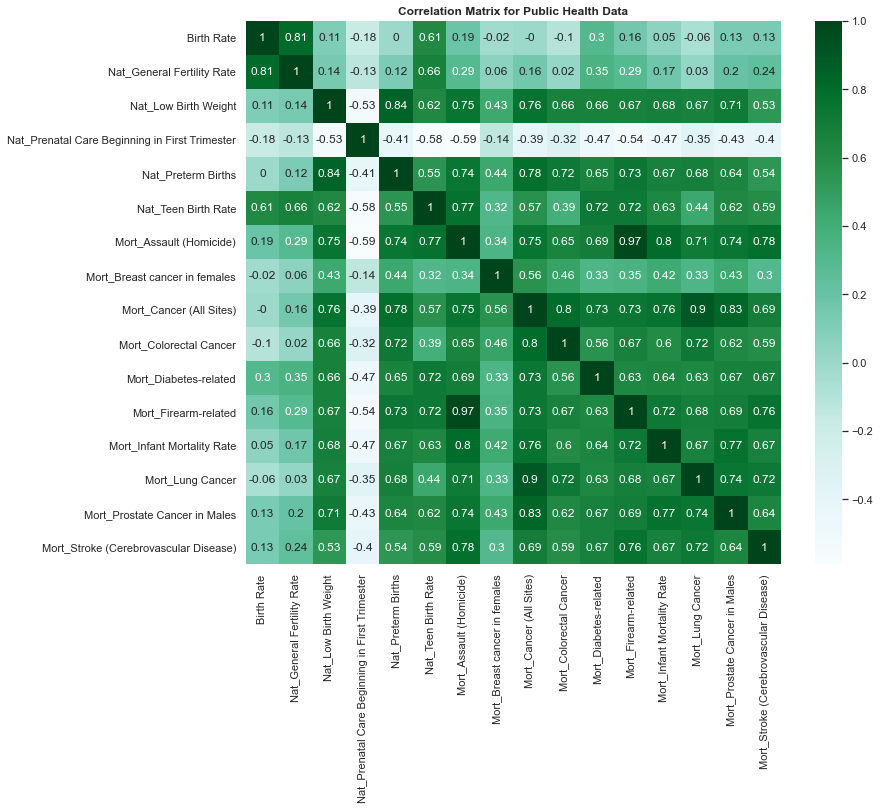

In [40]:
fig, ax = plt.subplots(figsize=(12, 10))
fig = sns.heatmap(df_health.set_index(['Community_Area_Number',
                                      'Community_Area_Name']).
                  corr().round(2), cmap='BuGn', annot=True, ax=ax)
fig.set_title('Correlation Matrix for Public Health Data', weight='bold')
plt.show()

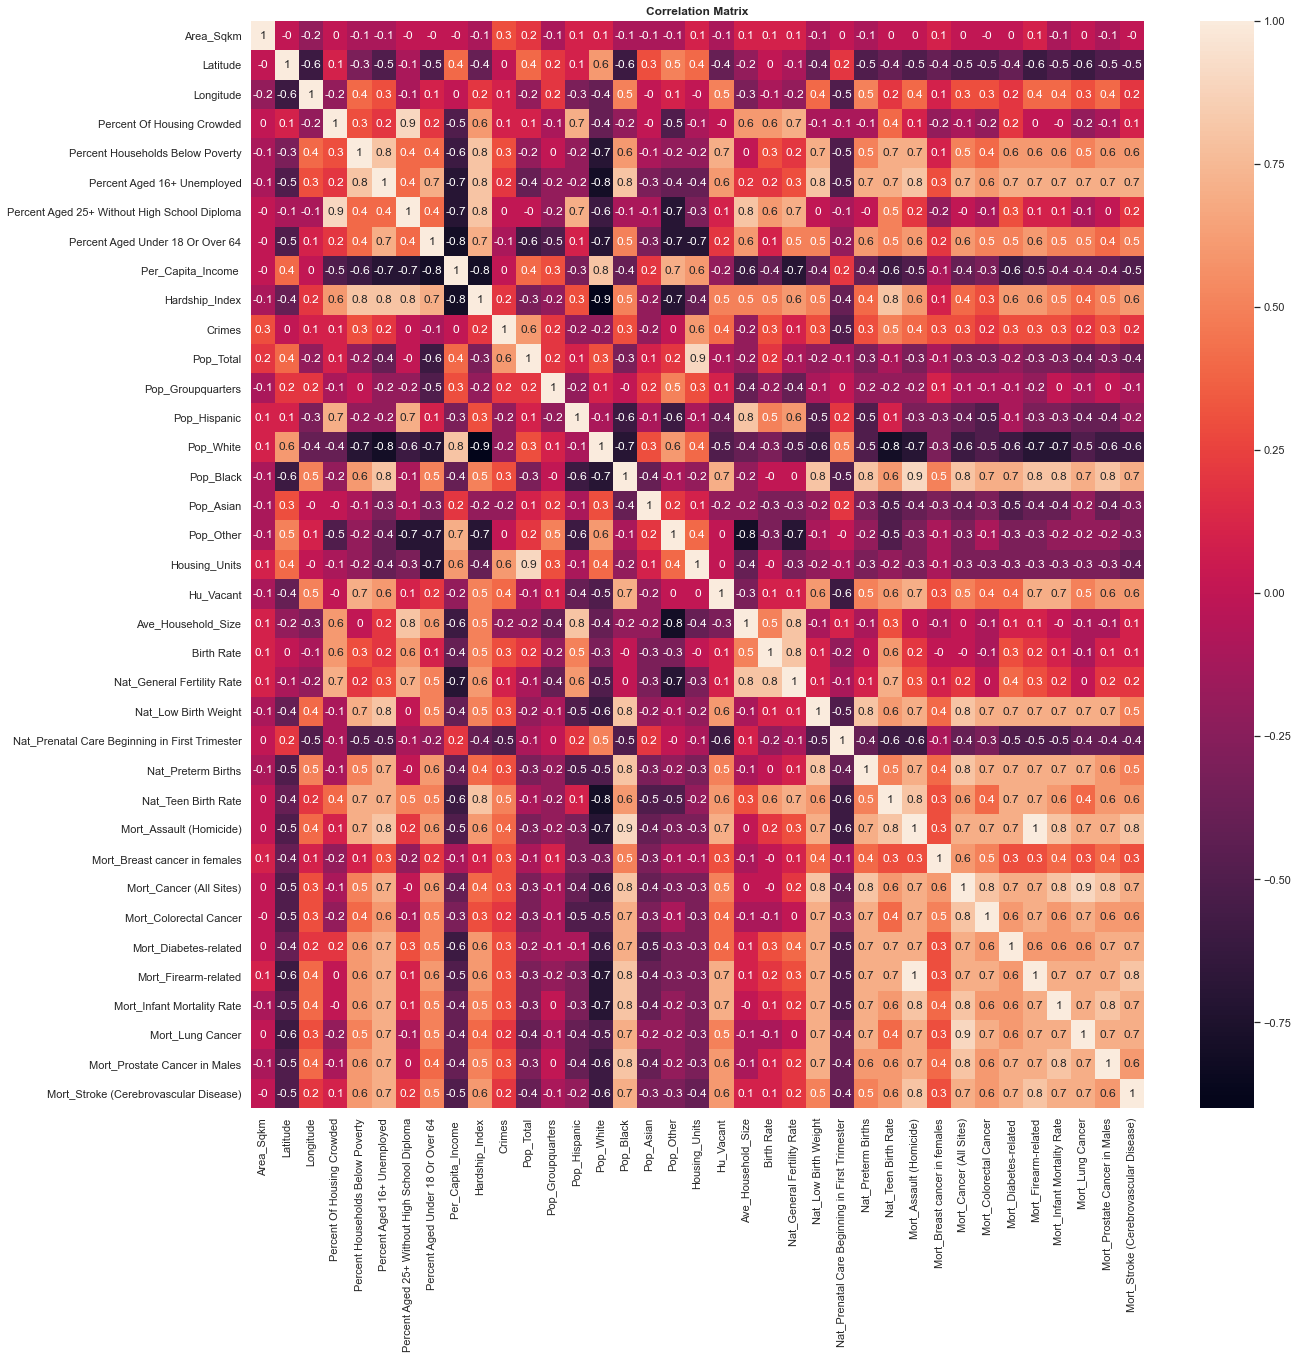

In [41]:
fig, ax = plt.subplots(figsize=(20, 20))
fig = sns.heatmap(df_all.corr().round(1), annot=True, ax=ax)
fig.set_title('Correlation Matrix', weight='bold')
plt.show()

### Building the Model

In [238]:
X = np.array(df_all)
y = np.array(df_targets['Trust_Score'])
feature_names = df_all.columns

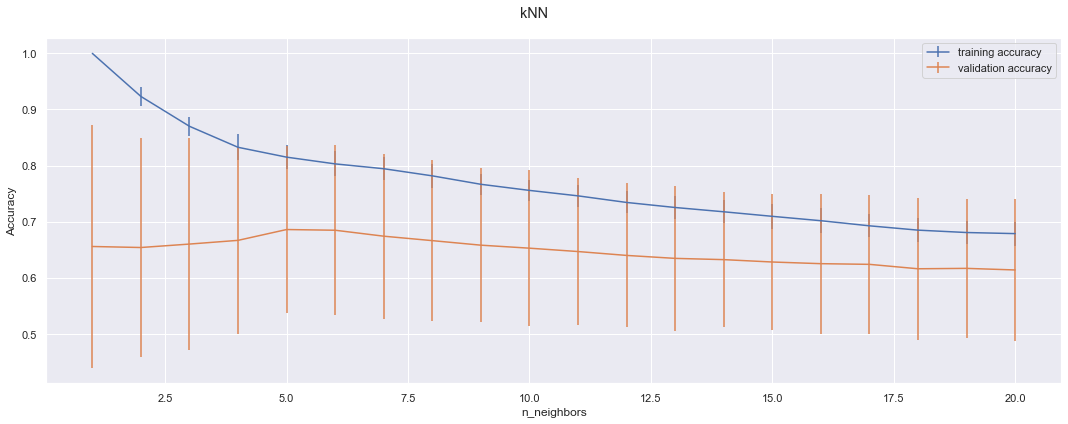

,model_top_parameter,mean_train_score,std_train_score,mean_test_score,std_test_score,top_predictor,run_time
0,'kNN__n_neighbors': 5,0.814927,0.020886,0.685818,0.149183,N/A,7.242826


In [239]:
# kNN

def train_knn():
    start_time = time.time()
    steps = [('scaler', StandardScaler()),
             ('kNN', KNeighborsRegressor())]
    pipeline = Pipeline(steps)

    param_range = range(1, 21)
    params = {'kNN__n_neighbors': param_range}
    model = list(params.keys())[0].split('__')[0]
    hyperparam = list(params.keys())[0].split('__')[1]

    cv = RepeatedKFold(n_splits=6, n_repeats=10, random_state=1)

    grid_search = GridSearchCV(pipeline, refit=True, param_grid=params,
                               cv=cv, return_train_score=True)
    grid_search.fit(X, y)

    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df = (results_df[['params', 'rank_test_score',
                              'mean_train_score', 'std_train_score',
                              'mean_test_score', 'std_test_score']])

    fig = plt.figure(figsize=(15, 6))
    plt.errorbar(param_range, results_df['mean_train_score'],
                  yerr=results_df['std_train_score'], label="training accuracy")
    plt.errorbar(param_range, results_df['mean_test_score'],
                  yerr=results_df['std_test_score'], label="validation accuracy")
    plt.ylabel("Accuracy", fontsize=12)
    plt.xlabel(hyperparam, fontsize=12)
    plt.suptitle(model)
    plt.legend()
    plt.tight_layout()
    plt.show()

    results_df = results_df.sort_values(by=['rank_test_score']).reset_index(drop=True)
    top_result = results_df[:1].copy()
    top_result['params'] = top_result['params'].astype(str).str.extract(r'{(.+)}')
    top_result = top_result.rename(columns={'params': 'model_top_parameter'})
    top_result = top_result.drop(['rank_test_score'], axis=1)
    top_result['top_predictor'] = 'N/A'
    top_result['run_time'] = (time.time() - start_time)
    display(top_result)
    return top_result


knn_results = train_knn()

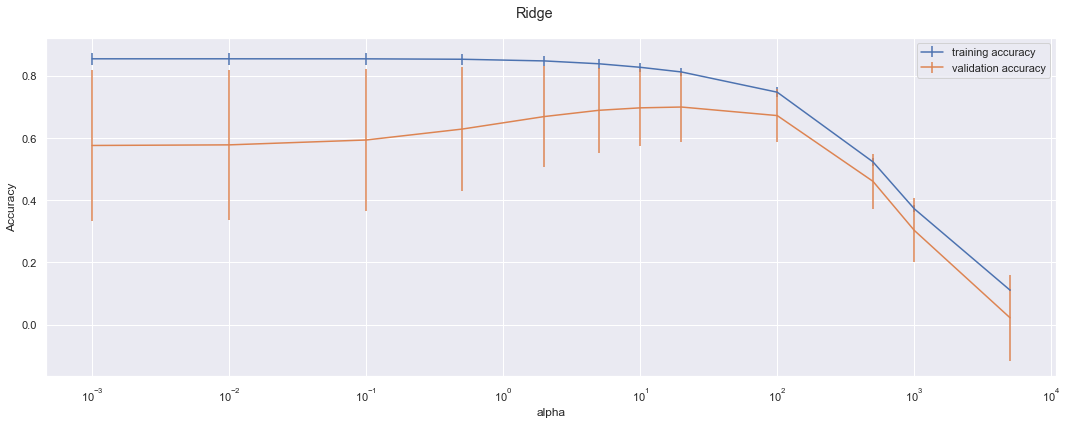

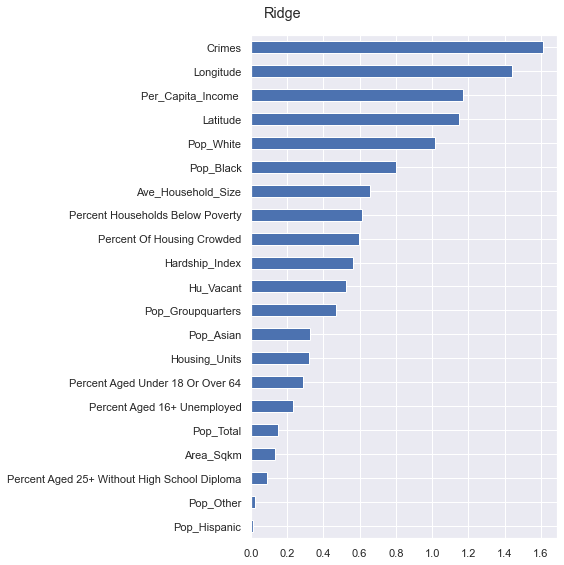

,model_top_parameter,mean_train_score,std_train_score,mean_test_score,std_test_score,top_predictor,run_time
0,'Ridge__alpha': 20,0.81145,0.014298,0.698849,0.112439,Crimes,8.482562


In [240]:
# Ridge

def train_ridge():
    start_time = time.time()
    steps = [('scaler', StandardScaler()),
             ('Ridge', Ridge(random_state=1))]
    pipeline = Pipeline(steps)

    param_range = [1e-3, 1e-2, 0.1, 0.5, 2, 5, 10,  20, 100, 500, 1000, 5000]
    params = {'Ridge__alpha': param_range}
    model = list(params.keys())[0].split('__')[0]
    hyperparam = list(params.keys())[0].split('__')[1]

    cv = RepeatedKFold(n_splits=6, n_repeats=10, random_state=1)

    grid_search = GridSearchCV(pipeline, refit=True, param_grid=params,
                               cv=cv, return_train_score=True)
    grid_search.fit(X, y)

    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df = (results_df[['params', 'rank_test_score',
                              'mean_train_score', 'std_train_score',
                              'mean_test_score', 'std_test_score']])

    fig = plt.figure(figsize=(15, 6))
    plt.errorbar(param_range, results_df['mean_train_score'],
                  yerr=results_df['std_train_score'], label="training accuracy")
    plt.errorbar(param_range, results_df['mean_test_score'],
                  yerr=results_df['std_test_score'], label="validation accuracy")
    plt.ylabel("Accuracy", fontsize=12)
    plt.xlabel(hyperparam, fontsize=12)
    plt.xscale('log')
    plt.suptitle(model)
    plt.legend()
    plt.tight_layout()
    plt.show()

    s_predictors = pd.Series(grid_search.best_estimator_.named_steps['Ridge'].coef_).abs()
    s_predictors.index = feature_names
    s_predictors = s_predictors.sort_values()

    fig, ax = plt.subplots(figsize=(8, 8))
    ax = s_predictors.plot(kind='barh')
    plt.suptitle(model)
    plt.tight_layout()
    plt.show()

    results_df = results_df.sort_values(by=['rank_test_score']).reset_index(drop=True)
    top_result = results_df[:1].copy()
    top_result['params'] = top_result['params'].astype(str).str.extract(r'{(.+)}')
    top_result = top_result.rename(columns={'params': 'model_top_parameter'})
    top_result = top_result.drop(['rank_test_score'], axis=1)
    top_result['top_predictor'] = s_predictors.nlargest().index[0]
    top_result['run_time'] = (time.time() - start_time)
    display(top_result)
    return top_result


ridge_results = train_ridge()

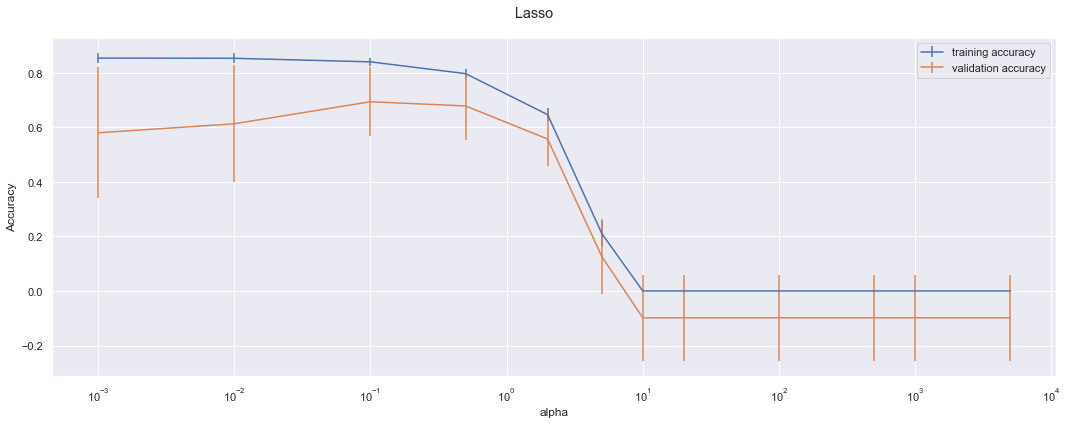

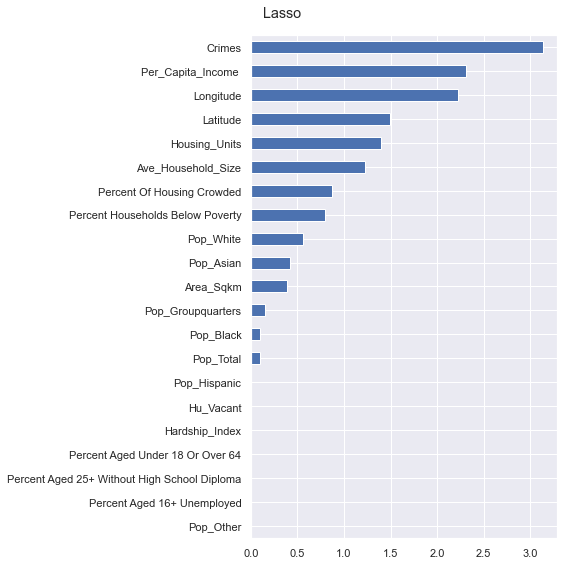

,model_top_parameter,mean_train_score,std_train_score,mean_test_score,std_test_score,top_predictor,run_time
0,'Lasso__alpha': 0.1,0.839913,0.014843,0.69368,0.126517,Crimes,7.528886


In [241]:
# Lasso

def train_lasso():
    start_time = time.time()
    steps = [('scaler', StandardScaler()),
             ('Lasso', Lasso(max_iter=7000, random_state=1))]
    pipeline = Pipeline(steps)

    param_range = [1e-3, 1e-2, 0.1, 0.5, 2, 5, 10,  20, 100, 500, 1000, 5000]
    params = {'Lasso__alpha': param_range}
    model = list(params.keys())[0].split('__')[0]
    hyperparam = list(params.keys())[0].split('__')[1]

    cv = RepeatedKFold(n_splits=6, n_repeats=10, random_state=1)

    grid_search = GridSearchCV(pipeline, refit=True, param_grid=params,
                               cv=cv, return_train_score=True)
    grid_search.fit(X, y)

    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df = (results_df[['params', 'rank_test_score',
                              'mean_train_score', 'std_train_score',
                              'mean_test_score', 'std_test_score']])

    fig = plt.figure(figsize=(15, 6))
    plt.errorbar(param_range, results_df['mean_train_score'],
                  yerr=results_df['std_train_score'], label="training accuracy")
    plt.errorbar(param_range, results_df['mean_test_score'],
                  yerr=results_df['std_test_score'], label="validation accuracy")
    plt.ylabel("Accuracy", fontsize=12)
    plt.xlabel(hyperparam, fontsize=12)
    plt.xscale('log')
    plt.suptitle(model)
    plt.legend()
    plt.tight_layout()
    plt.show()

    s_predictors = pd.Series(grid_search.best_estimator_.named_steps['Lasso'].coef_).abs()
    s_predictors.index = feature_names
    s_predictors = s_predictors.sort_values()

    fig, ax = plt.subplots(figsize=(8, 8))
    ax = s_predictors.plot(kind='barh')
    plt.suptitle(model)
    plt.tight_layout()
    plt.show()

    results_df = results_df.sort_values(by=['rank_test_score']).reset_index(drop=True)
    top_result = results_df[:1].copy()
    top_result['params'] = top_result['params'].astype(str).str.extract(r'{(.+)}')
    top_result = top_result.rename(columns={'params': 'model_top_parameter'})
    top_result = top_result.drop(['rank_test_score'], axis=1)
    top_result['top_predictor'] = s_predictors.nlargest().index[0]
    top_result['run_time'] = (time.time() - start_time)
    display(top_result)
    return top_result


lasso_results = train_lasso()

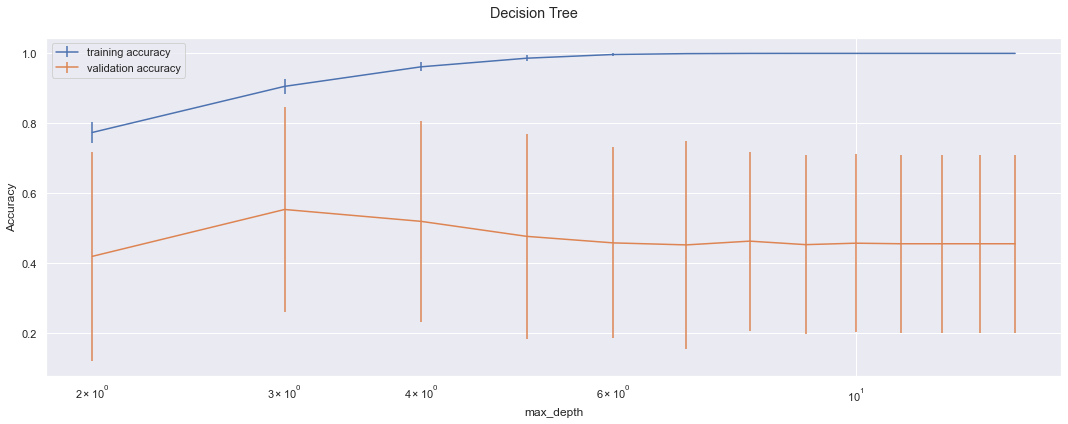

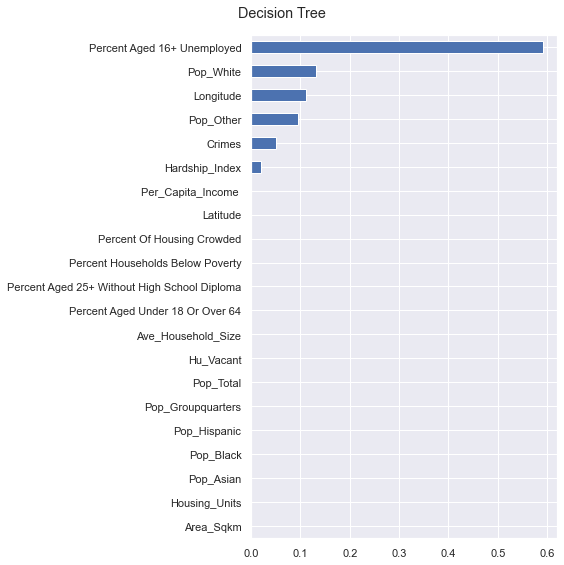

,model_top_parameter,mean_train_score,std_train_score,mean_test_score,std_test_score,top_predictor,run_time
0,'DT__max_depth': 3,0.905713,0.021515,0.553751,0.291892,Percent Aged 16+ Unemployed,6.443711


In [242]:
# Decision Tree

def train_DT():
    start_time = time.time()
    steps = [('scaler', StandardScaler()),
             ('DT', DecisionTreeRegressor(random_state=1))]
    pipeline = Pipeline(steps)

    param_range = range(2, 15)
    params = {'DT__max_depth': param_range}
    model = 'Decision Tree'
    hyperparam = list(params.keys())[0].split('__')[1]

    cv = RepeatedKFold(n_splits=6, n_repeats=10, random_state=1)

    grid_search = GridSearchCV(pipeline, refit=True, param_grid=params,
                               cv=cv, return_train_score=True)
    grid_search.fit(X, y)

    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df = (results_df[['params', 'rank_test_score',
                              'mean_train_score', 'std_train_score',
                              'mean_test_score', 'std_test_score']])

    fig = plt.figure(figsize=(15, 6))
    plt.errorbar(param_range, results_df['mean_train_score'],
                  yerr=results_df['std_train_score'], label="training accuracy")
    plt.errorbar(param_range, results_df['mean_test_score'],
                  yerr=results_df['std_test_score'], label="validation accuracy")
    plt.ylabel("Accuracy", fontsize=12)
    plt.xlabel(hyperparam, fontsize=12)
    plt.xscale('log')
    plt.suptitle(model)
    plt.legend()
    plt.tight_layout()
    plt.show()

    s_predictors = pd.Series(grid_search.best_estimator_
                             .named_steps['DT'].feature_importances_).abs()
    s_predictors.index = feature_names
    s_predictors = s_predictors.sort_values()

    fig, ax = plt.subplots(figsize=(8, 8))
    ax = s_predictors.plot(kind='barh')
    plt.suptitle(model)
    plt.tight_layout()
    plt.show()

    results_df = results_df.sort_values(by=['rank_test_score']).reset_index(drop=True)
    top_result = results_df[:1].copy()
    top_result['params'] = top_result['params'].astype(str).str.extract(r'{(.+)}')
    top_result = top_result.rename(columns={'params': 'model_top_parameter'})
    top_result = top_result.drop(['rank_test_score'], axis=1)
    top_result['top_predictor'] = s_predictors.nlargest().index[0]
    top_result['run_time'] = (time.time() - start_time)
    display(top_result)
    return top_result


DT_results = train_DT()

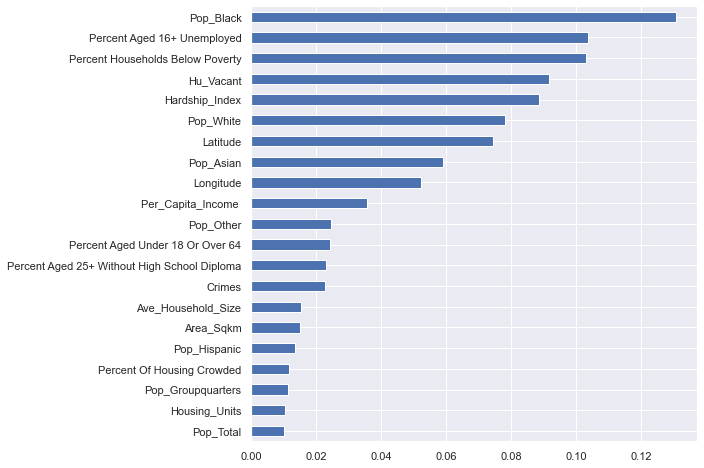

,model_top_parameter,mean_train_score,std_train_score,mean_test_score,std_test_score,top_predictor,run_time
0,"'RF__max_depth': 5, 'RF__max_features': 'sqrt'",0.951907,0.005851,0.708469,0.093499,Pop_Black,85.642632


In [243]:
# Random Forest

def train_RF():
    start_time = time.time()
    steps = [('scaler', StandardScaler()),
             ('RF', RandomForestRegressor(n_estimators=50, random_state=1))]
    pipeline = Pipeline(steps)

    model = 'Random Forest'
    params = {'RF__max_depth': range(2, 10),
              'RF__max_features': ['sqrt', 'log2', 'auto']}
    cv = RepeatedKFold(n_splits=6, n_repeats=5, random_state=1)

    grid_search = GridSearchCV(pipeline, refit=True, param_grid=params,
                               cv=cv, return_train_score=True)
    grid_search.fit(X, y)

    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df = (results_df[['params', 'rank_test_score',
                              'mean_train_score', 'std_train_score',
                              'mean_test_score', 'std_test_score']])

    s_predictors = pd.Series(grid_search.best_estimator_
                             .named_steps['RF'].feature_importances_).abs()
    s_predictors.index = feature_names
    s_predictors = s_predictors.sort_values()

    fig, ax = plt.subplots(figsize=(8, 8))
    ax = s_predictors.plot(kind='barh')
    plt.show()

    results_df = results_df.sort_values(by=['rank_test_score']).reset_index(drop=True)
    top_result = results_df[:1].copy()
    top_result['params'] = top_result['params'].astype(str).str.extract(r'{(.+)}')
    top_result = top_result.rename(columns={'params': 'model_top_parameter'})
    top_result = top_result.drop(['rank_test_score'], axis=1)
    top_result['top_predictor'] = s_predictors.nlargest().index[0]
    top_result['run_time'] = (time.time() - start_time)
    display(top_result)
    return top_result


RF_results = train_RF()

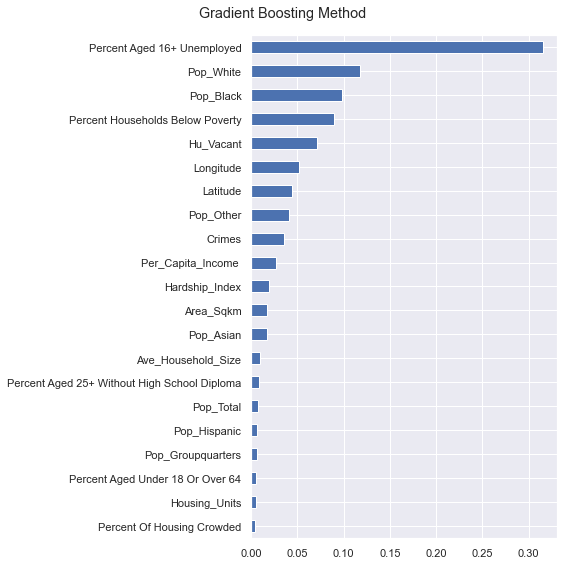

,model_top_parameter,mean_train_score,std_train_score,mean_test_score,std_test_score,top_predictor,run_time
0,"'GB__learning_rate': 0.05, 'GB__max_depth': 6, 'GB__max_features': 0.4",0.993755,0.000101,0.715063,0.102913,Percent Aged 16+ Unemployed,96.523883


In [244]:
# Gradient Boosting Method

def train_GB():
    start_time = time.time()
    steps = [('scaler', StandardScaler()),
             ('GB', GradientBoostingRegressor(n_estimators=50, random_state=1))]
    pipeline = Pipeline(steps)

    model = 'Gradient Boosting Method'
    params = {'GB__max_depth': range(2, 7),
              'GB__max_features': [0.2, 0.4, 0.6, 0.8],
              'GB__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2]}
    cv = RepeatedKFold(n_splits=6, n_repeats=5, random_state=1)

    grid_search = GridSearchCV(pipeline, refit=True, param_grid=params,
                               cv=cv, return_train_score=True)
    grid_search.fit(X, y)

    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df = (results_df[['params', 'rank_test_score',
                              'mean_train_score', 'std_train_score',
                              'mean_test_score', 'std_test_score']])

    s_predictors = pd.Series(grid_search.best_estimator_
                             .named_steps['GB'].feature_importances_).abs()
    s_predictors.index = feature_names
    s_predictors = s_predictors.sort_values()

    fig, ax = plt.subplots(figsize=(8, 8))
    ax = s_predictors.plot(kind='barh')
    plt.suptitle(model)
    plt.tight_layout()
    plt.show()

    results_df = results_df.sort_values(by=['rank_test_score']).reset_index(drop=True)
    top_result = results_df[:1].copy()
    top_result['params'] = top_result['params'].astype(str).str.extract(r'{(.+)}')
    top_result = top_result.rename(columns={'params': 'model_top_parameter'})
    top_result = top_result.drop(['rank_test_score'], axis=1)
    top_result['top_predictor'] = s_predictors.nlargest().index[0]
    top_result['run_time'] = (time.time() - start_time)
    display(top_result)
    return top_result


GB_results = train_GB()

### Results and Discussion

In [245]:
summary = pd.concat([knn_results,
                     ridge_results,
                     lasso_results,
                     DT_results,
                     RF_results,
                     GB_results], axis=0)
summary = summary.drop(['std_train_score', 'std_test_score'], axis=1)
summary

,model_top_parameter,mean_train_score,mean_test_score,top_predictor,run_time
0,'kNN__n_neighbors': 5,0.814927,0.685818,N/A,7.242826
0,'Ridge__alpha': 20,0.811450,0.698849,Crimes,8.482562
0,'Lasso__alpha': 0.1,0.839913,0.693680,Crimes,7.528886
0,'DT__max_depth': 3,0.905713,0.553751,Percent Aged 16+ Unemployed,6.443711
0,"'RF__max_depth': 5, 'RF__max_features': 'sqrt'",0.951907,0.708469,Pop_Black,85.642632
0,"'GB__learning_rate': 0.05, 'GB__max_depth': 6, 'GB__max_features': 0.4",0.993755,0.715063,Percent Aged 16+ Unemployed,96.523883


### Conclusions